# DAAI Project 3 - Train On CityScapes (step 2a)

## Data Preparation

### Clone the professor's repository

In [ ]:
!git clone https://github.com/ClaudiaCuttano/AML_Semantic_DA.git

Cloning into 'AML_Semantic_DA'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 18 (delta 0), reused 0 (delta 0), pack-reused 13
Receiving objects: 100% (18/18), 10.88 KiB | 928.00 KiB/s, done.


### Mount Google Drive to access files

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


### Replace the empty 'cityscapes.py' with the one in this repo

In [ ]:
!cp datasets/cityscapes.py AML_Semantic_DA/cityscapes.py

### Extract the CityScapes dataset

In [ ]:
import zipfile

with zipfile.ZipFile(f'drive/MyDrive/cityscapes.zip', 'r') as zip_ref:
  zip_ref.extractall()

### Copy the pre-trained model to Colab

In [ ]:
!cp drive/MyDrive/STDCNet813M_73.91.tar STDCNet813M_73.91.tar

### Install tensorboardX

In [ ]:
!pip install tensorboardX

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 2.8 MB/s eta 0:00:00


## Train the model

In [ ]:
!python AML_Semantic_DA/train.py \
--save_model_path drive/MyDrive/cityscapes_checkpoints/ \
--backbone STDCNet813 \
--mode train \
--pretrain_path STDCNet813M_73.91.tar \
--num_workers 2 \
--num_epochs 50 \
--batch_size 2 \
--validation_step 1 \
--learning_rate 0.01

use pretrain model STDCNet813M_73.91.tar
start val!
precision per pixel for test: 0.367
mIoU for validation: 0.115
mIoU per class: [2.33564919e-01 6.12831309e-02 4.91293993e-01 1.18408570e-02
 3.31992400e-03 4.20729809e-02 2.00557091e-02 4.77190303e-04
 5.62776101e-01 5.40969292e-02 5.24457306e-01 5.37317749e-03
 4.02935203e-03 1.28692987e-01 2.86702577e-02 3.70098995e-04
 4.11864165e-04 5.62907221e-03 0.00000000e+00]


## Visualize The Results

### Create dataset and dataloader

In [ ]:
from pathlib import Path
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
from AML_Semantic_DA.cityscapes import CityScapes


BATCH_SIZE = 1
NUM_WORKERS = os.cpu_count()
num_classes = 19

val_dataset = CityScapes(
    mode='val'
    )
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True
)

In [ ]:
data, label = next(iter(val_loader))

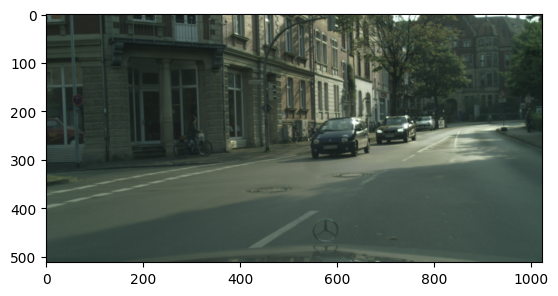

In [ ]:
plt.imshow(data[0].permute(1,2,0).cpu())

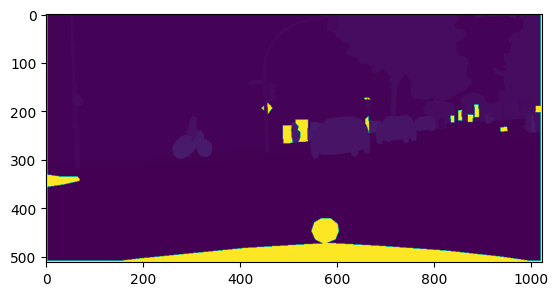

In [ ]:
plt.imshow(label[0].permute(1,2,0).cpu())

### Load the trained model

In [ ]:
from AML_Semantic_DA.model.model_stages import BiSeNet
import torch

model = BiSeNet(backbone='STDCNet813', n_classes=num_classes, pretrain_model='STDCNet813M_73.91.tar', use_conv_last=False)
model.load_state_dict(torch.load('best.pth', map_location='cpu'))
model = torch.nn.DataParallel(model).cuda()

### Get an image and its label

In [ ]:
data, label = next(iter(val_loader))

### Generate prediction and calculate metrics

In [ ]:
import numpy as np
from AML_Semantic_DA.utils import poly_lr_scheduler
from AML_Semantic_DA.utils import reverse_one_hot, compute_global_accuracy, fast_hist, per_class_iu

with torch.no_grad():
  model.eval()
  hist = np.zeros((num_classes, num_classes))
  label = label.type(torch.LongTensor)
  data = data.cuda()
  label = label.long().cuda()

  # get RGB predict image
  predict, _, _ = model(data)
  predict = predict.squeeze(0)
  predict = reverse_one_hot(predict)
  predict = np.array(predict.cpu())

  # get RGB label image
  label = label.squeeze()
  label = np.array(label.cpu())

  # compute per pixel accuracy
  precision = compute_global_accuracy(predict, label)
  hist += fast_hist(label.flatten(), predict.flatten(), num_classes)

  precision = np.mean(precision_record)
  miou_list = per_class_iu(hist)
  miou = np.mean(miou_list)
  print('precision per pixel for test: %.3f' % precision)
  print('mIoU for validation: %.3f' % miou)
  print(f'mIoU per class: {miou_list}')

### Show the pictures

In [ ]:
plt.imshow(data[0].permute(1,2,0).cpu())

In [ ]:
label[label==255] = 0
plt.imshow(label)

In [ ]:
plt.imshow(predict)